In [328]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# Function to label open nodes, overlapping interior nodes and triple junctions automatically
def label_nodes(els):
    n_els = len(els.x1)
    # first find all unique points
    points = np.zeros((2 * n_els, 2))
    x1y1 = np.vstack((els.x1, els.y1)).T
    x2y2 = np.vstack((els.x2, els.y2)).T
    points[0::2, :] = x1y1
    points[1::2, :] = x2y2
    unique_points, id_unique = np.unique(points, axis=0, return_index=True)

    # Find number of open, 2-overlap & triple junction nodes
    index_matrix1 = []
    index_matrix2 = []
    index_matrix3 = []
    for i in range(len(unique_points)):
        pts = unique_points[i, :].reshape(1, -1)

        # Which element(s) contains this point
        id1 = np.where(np.all(pts == x1y1, axis=1))
        id2 = np.where(np.all(pts == x2y2, axis=1))

        # The negative signs are for the triple junction equations
        # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
        if np.size(id1) == 2:
            id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
        elif np.size(id2) == 2:
            id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
        else:
            id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

        if np.size(id_combo) == 1:
            index_matrix1.append(id_combo)
        elif np.size(id_combo) == 2:
            index_matrix2.append(id_combo)
        elif np.size(id_combo) == 3:
            index_matrix3.append(id_combo)
        else:
            print(id_combo)
            raise ValueError("Cannot deal with more than 3 lines at a node")

    print("Number of open nodes =", len(index_matrix1))
    print(":", index_matrix1)
    print("Number of 2-overlap nodes =", len(index_matrix2))
    print(":", index_matrix2)
    print("Number of triple junctions =", len(index_matrix3))
    print(":", index_matrix3)

    return index_matrix1, index_matrix2, index_matrix3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['left_edge' 'mht' 'right_edge' 'topo']


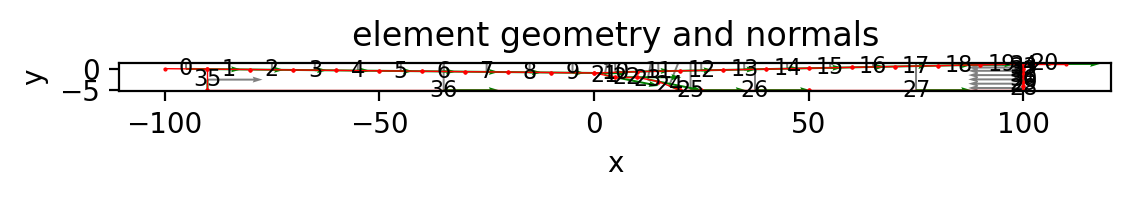

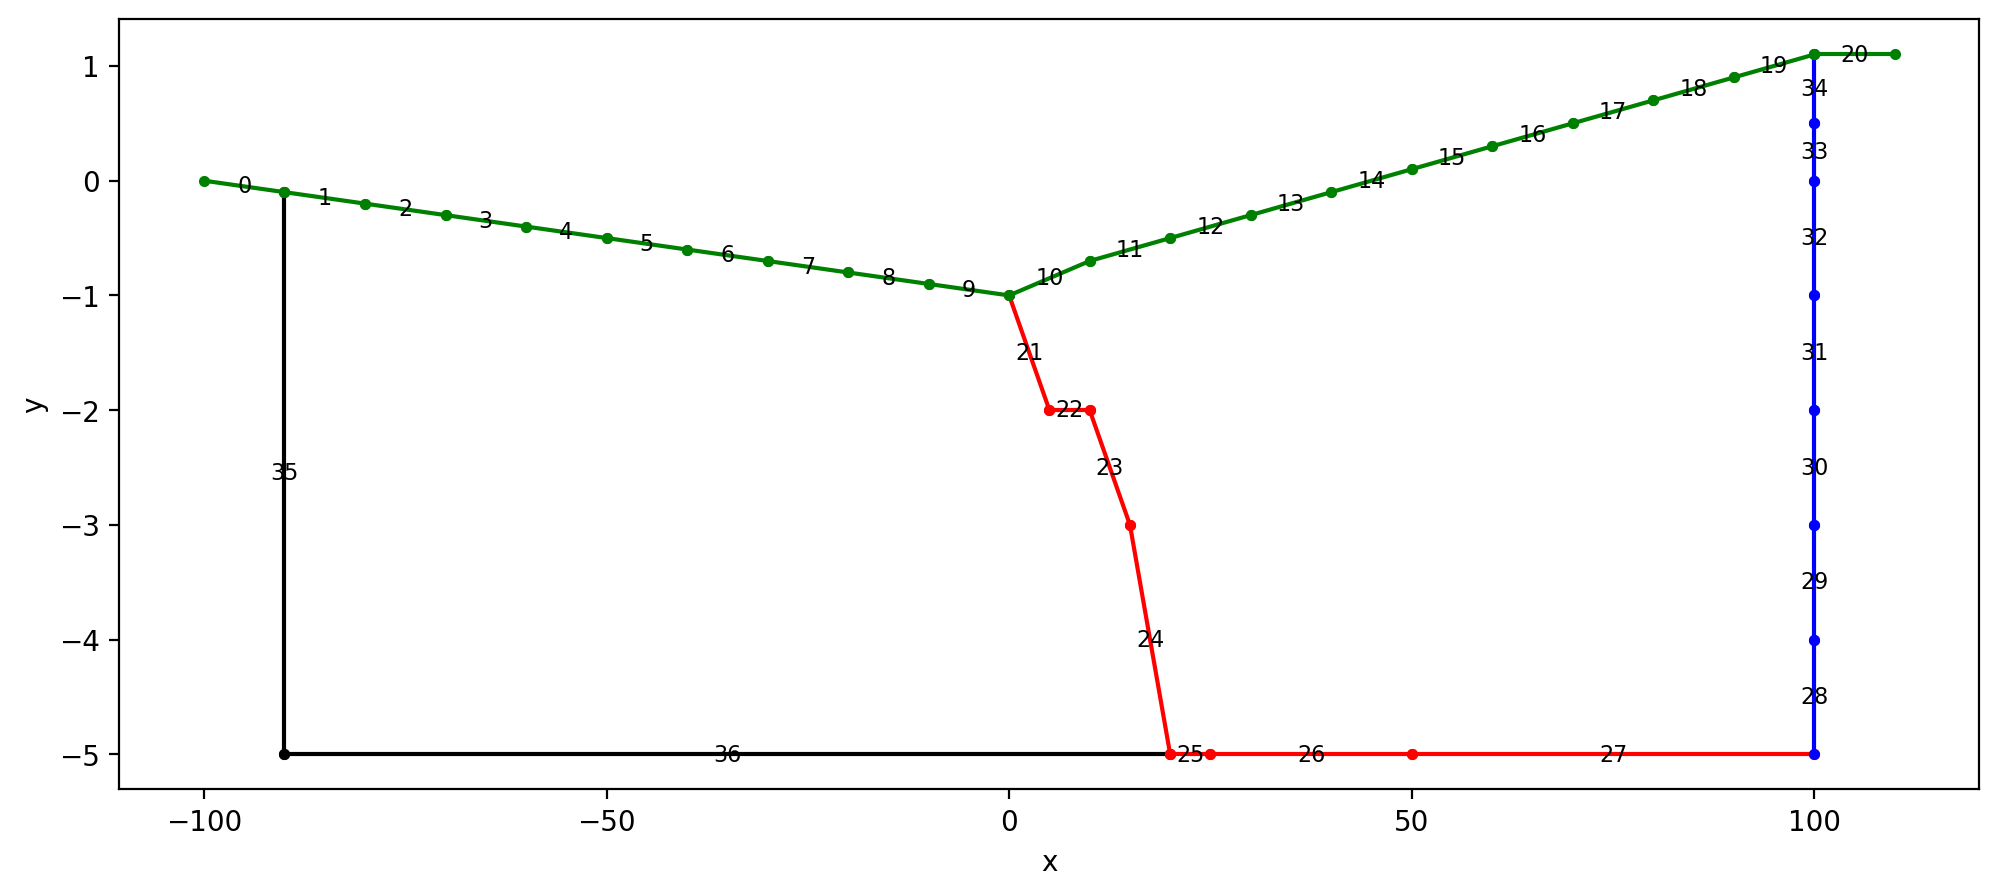

In [329]:
# Elastic parameters
mu = 5
nu = 0.25

# read fault geometry files
# fileinput = pd.read_csv("mht_geometry_5_km.csv")
fileinput = pd.read_csv("dummy_geometry.csv")

# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype = fileinput["bc_type"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
faultid = np.arange(n_els)
bemcs.plot_els_geometry(els)

plt.figure(figsize=(12, 5))
cval = "krbgcym"
count = 0
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        plt.plot(
            [els.x1[j], els.x2[j]], [els.y1[j], els.y2[j]], ".-", color=cval[count]
        )
        plt.text(
            els.x_centers[j],
            els.y_centers[j],
            str(faultid[j]),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )
    count += 1
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [330]:
index_open, index_overlap, index_triple = label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 2
: [array([0]), array([62])]
Number of 2-overlap nodes = 30
: [array([108, 107]), array([6, 5]), array([9, 8]), array([12, 11]), array([15, 14]), array([18, 17]), array([21, 20]), array([24, 23]), array([27, 26]), array([66, 65]), array([69, 68]), array([33, 32]), array([72, 71]), array([36, 35]), array([78, 77]), array([39, 38]), array([42, 41]), array([81, 80]), array([45, 44]), array([48, 47]), array([51, 50]), array([54, 53]), array([57, 56]), array([84, 83]), array([87, 86]), array([90, 89]), array([93, 92]), array([96, 95]), array([99, 98]), array([102, 101])]
Number of triple junctions = 4
: [array([  -3, -105,    2]), array([-30, -63,  29]), array([  75,  -74, -110]), array([  60,  -59, -104])]


In [331]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# topography - traction-free (tx,ty) = (0,0)
# right_edge - velocity specified
# left_edge - (vx,vy) = (0,0)
# base - traction-free (tx,ty) = (0,0)
# what to do about mbt, mct, ramp_mft?
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [332]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(els)

# Patch center locations (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
epsilonr = 1e-4 * (bctype == "u").astype(float)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/bemcs/bemcs.py:148: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


### Assemble linear operator for central nodes only

In [333]:
# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x,y-kernels
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        if bctype[j] == "u":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
                kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
        elif bctype[j] == "t":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
                kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
        elif bctype[j] == "s":
            # print(j)
            kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

### Open nodes, overlapping nodes & triple junctions

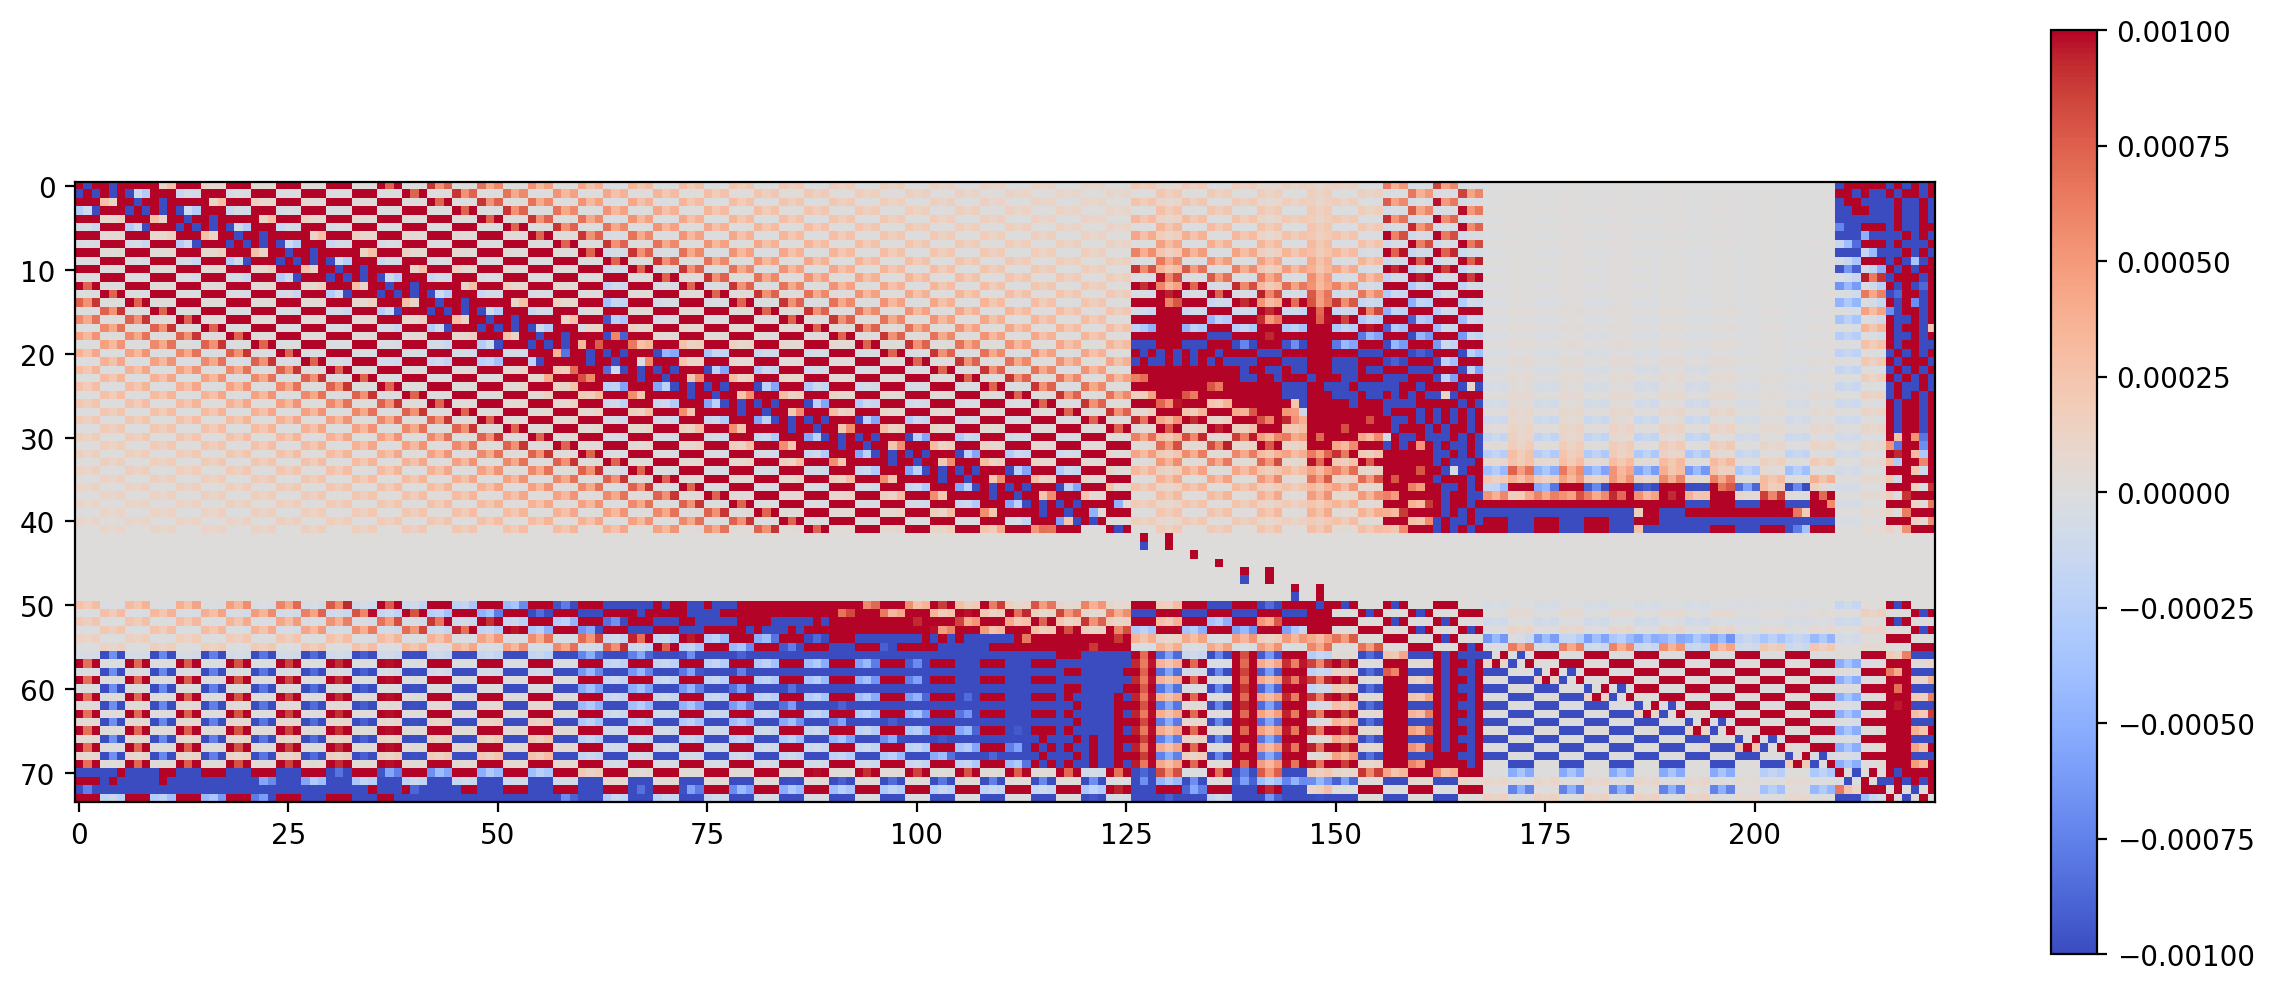

In [334]:
# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_open[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_overlap[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y

# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_triple[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system_c, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.001, 0.001)
plt.show()

# Solve system

In [335]:
# compute quadratic node coefficients (in local (s,n) coordinates)
# quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
quadratic_coefs = np.linalg.lstsq(matrix_system, BCvector, rcond=None)[0]
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 135815.82346101533


## Plot displacement and stress components in the medium

In [336]:
# Observation points
n_obs = 40
x_obs = np.linspace(-1, 31, n_obs)
y_obs = np.linspace(-6, 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

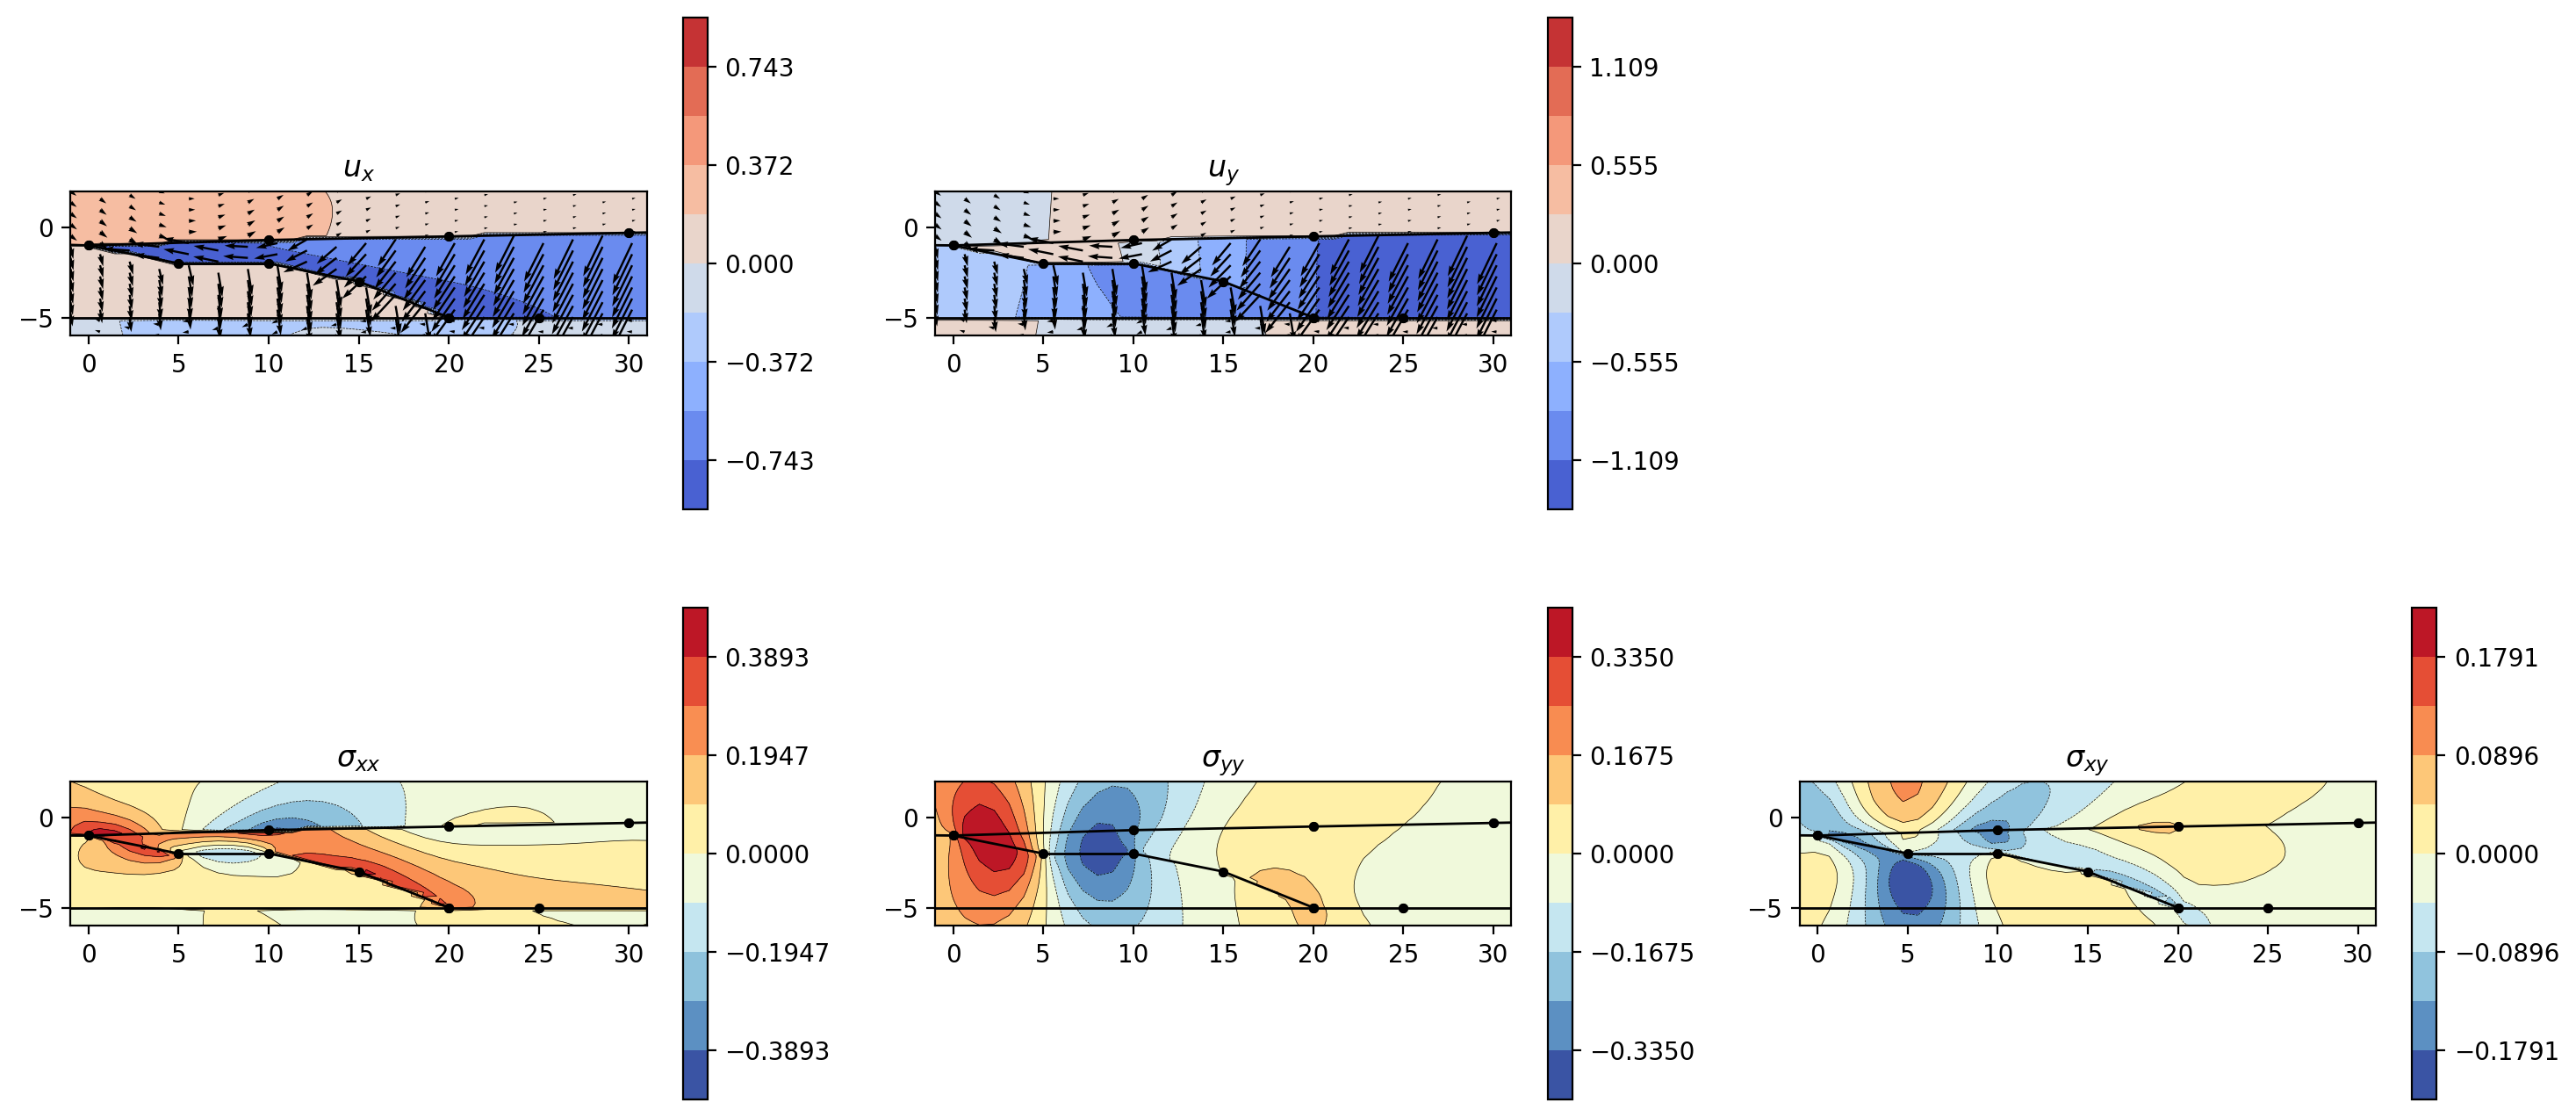

In [337]:
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=6
)

1.5410525091560037


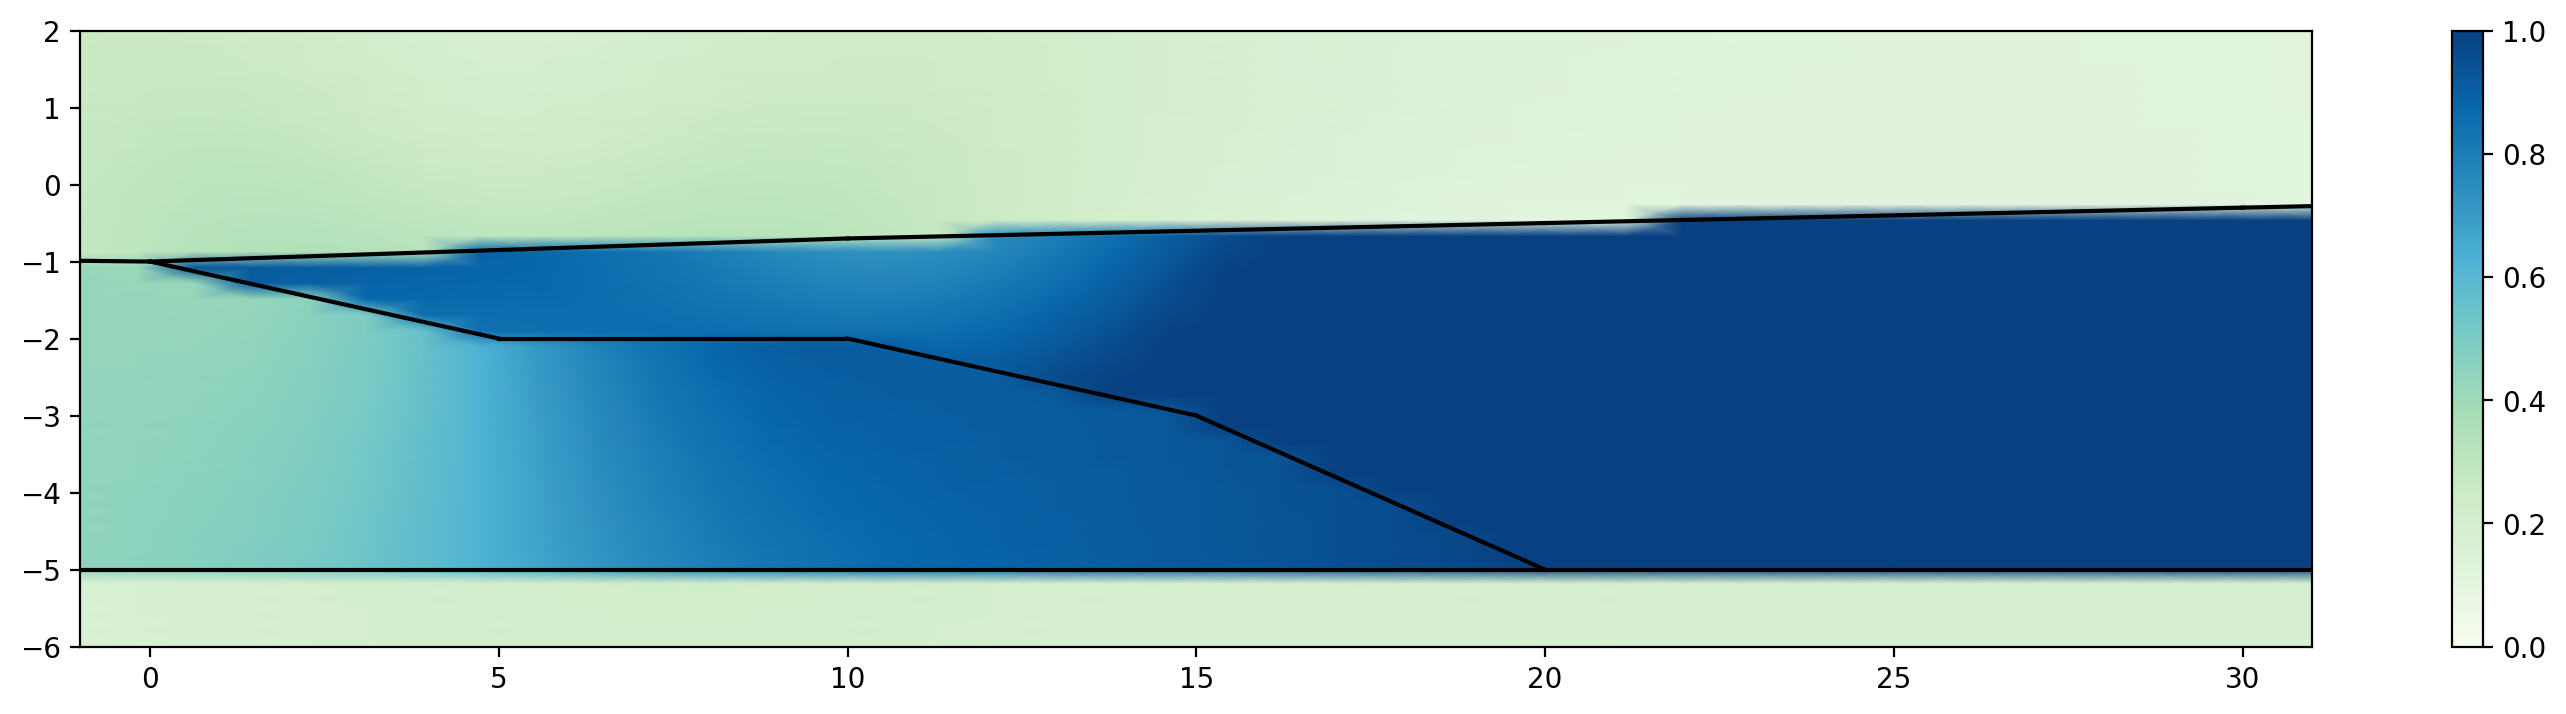

In [338]:
plt.figure(figsize=(18, 4))
maxval = 1
minval = 0
toplot = np.sqrt(ux.reshape(n_obs, n_obs) ** 2 + uy.reshape(n_obs, n_obs) ** 2)
# toplot = ux.reshape(n_obs, n_obs)
print(np.max(toplot))
n_skip_plot = 13
img = plt.pcolormesh(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="GnBu",
    vmin=minval,
    vmax=maxval,
    shading="gouraud",
)
plt.colorbar(img)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([np.min(x_obs), np.max(x_obs)])
plt.ylim([np.min(y_obs), np.max(y_obs)])
# plt.gca().set_aspect("equal", adjustable="box")
# plt.quiver(
#     x_obs[0::n_skip_plot],
#     y_obs[0::n_skip_plot],
#     ux[0::n_skip_plot],
#     uy[0::n_skip_plot],
#     width=0.001,
#     scale=20,
# )
plt.show()

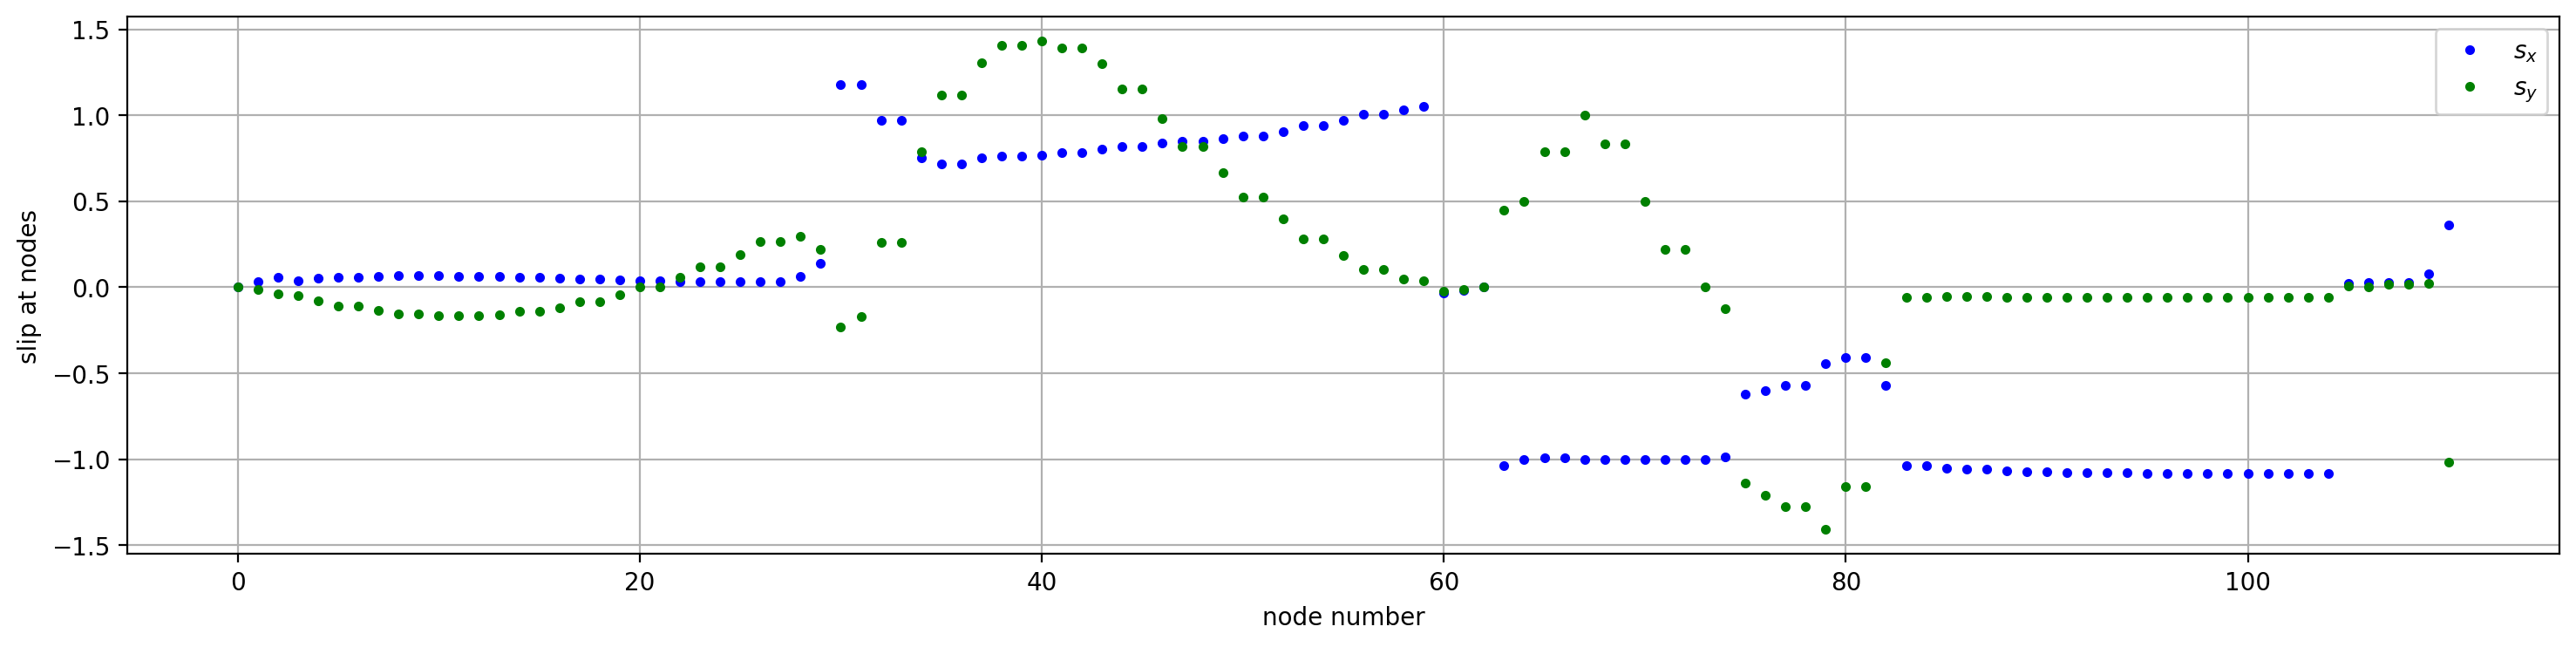

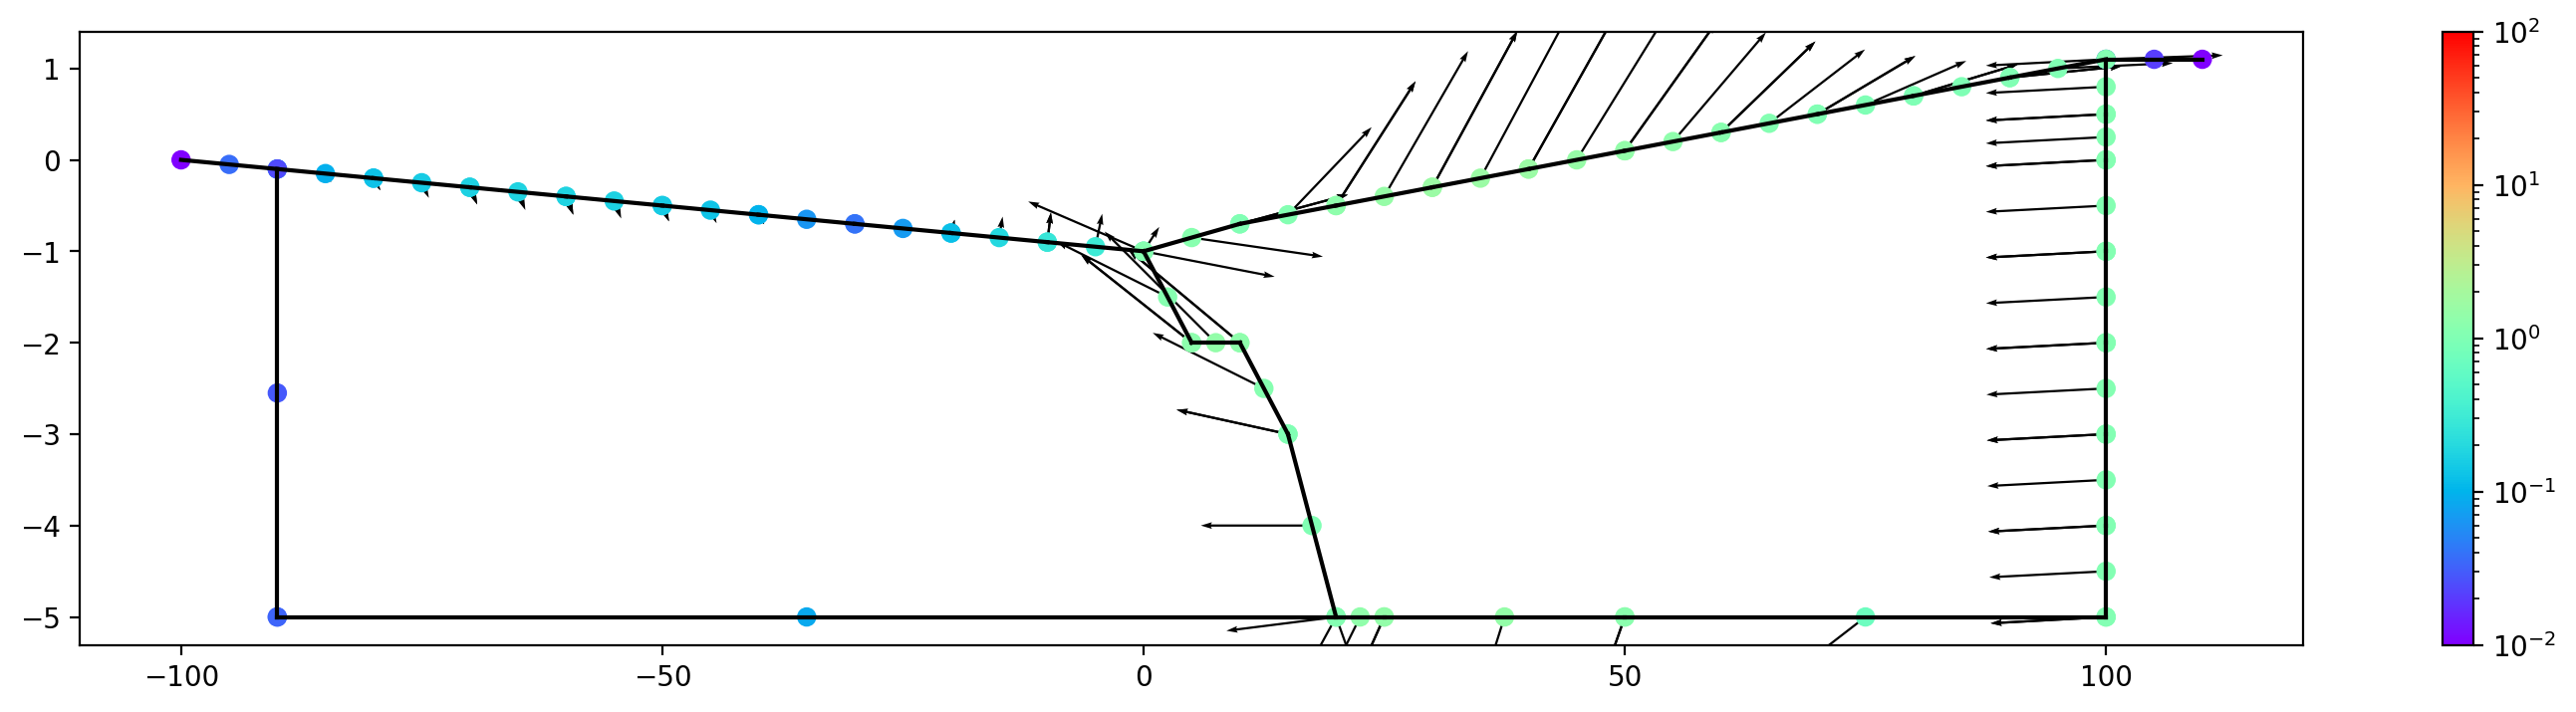

In [339]:
# Extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))
xnodes = np.zeros((3 * n_els, 1))
ynodes = np.zeros((3 * n_els, 1))
xnodes[0::3, 0] = els.x1
xnodes[2::3, 0] = els.x2
xnodes[1::3, 0] = els.x_centers
ynodes[0::3, 0] = els.y1
ynodes[2::3, 0] = els.y2
ynodes[1::3, 0] = els.y_centers

plt.figure(figsize=(18, 4))
plt.plot(slip_nodes_x, "b.", label="$s_x$")
plt.plot(slip_nodes_y, "g.", label="$s_y$")
plt.xlabel("node number")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()

from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 4))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.quiver(xnodes, ynodes, slip_nodes_x, slip_nodes_y, scale=20, width=0.001)
plt.scatter(
    xnodes,
    ynodes,
    c=np.sqrt(slip_nodes_x**2 + slip_nodes_y**2),
    label="Data Points",
    marker="o",
    cmap="rainbow",
    norm=LogNorm(vmin=0.01, vmax=100),
)
plt.colorbar()
plt.show()

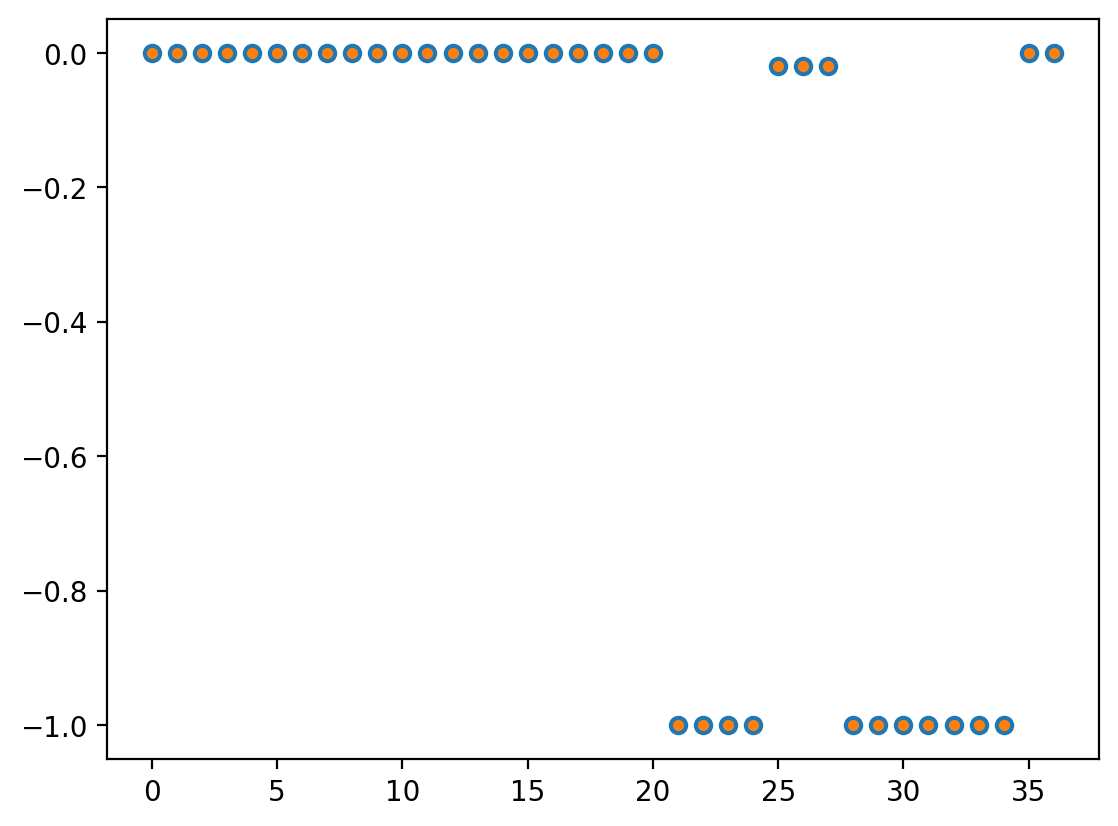

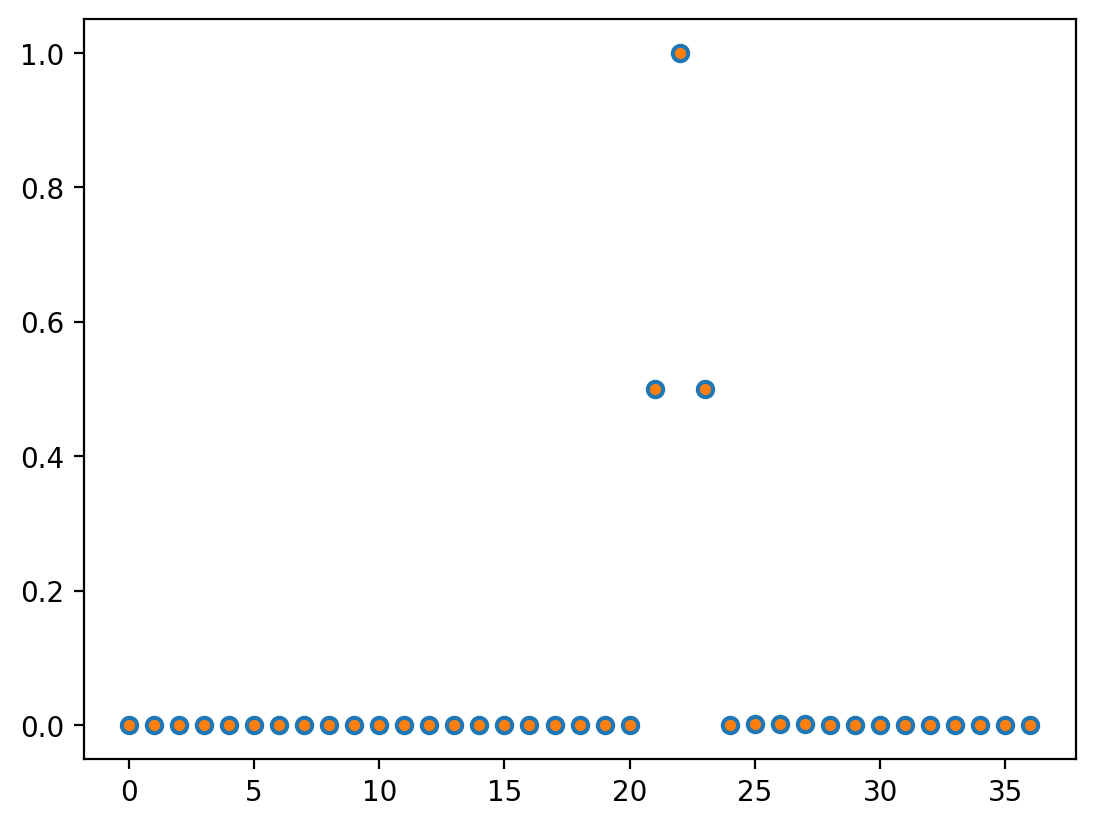

In [340]:
plt.plot(kerneleval_x @ quadratic_coefs - 0 * bc_x.reshape(-1, 1), "o")
plt.plot(bc_x, ".")
plt.show()
plt.plot(kerneleval_y @ quadratic_coefs - 0 * bc_y.reshape(-1, 1), "o")
plt.plot(bc_y, ".")
plt.show()